In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import cv2

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

2022-11-09 12:51:41.312152: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-09 12:51:41.628670: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-09 12:51:43.531768: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.0/lib64:/usr/local/cuda-10.0/lib64:/lhome/ext/uv075/uv0753/miniconda3/envs/cuda/lib/:/lhome/ext/uv075/uv0753/miniconda3/envs/cuda/lib/
2022-11-09 12:51:43.531859: W tensorflow/stream_ex

In [3]:
vgg = tf.keras.applications.VGG16(input_shape=(384,512,3),
                                  include_top=False,
                                  weights='imagenet')

print(vgg.summary())

2022-11-09 12:52:13.951621: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-11-09 12:52:13.951675: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: mlui01.ific.uv.es
2022-11-09 12:52:13.951687: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: mlui01.ific.uv.es
2022-11-09 12:52:13.951828: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 520.61.5
2022-11-09 12:52:13.951866: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 520.61.5
2022-11-09 12:52:13.951874: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 520.61.5
2022-11-09 12:52:13.952185: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CP

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 384, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 384, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 384, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 192, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 192, 256, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 192, 256, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 96, 128, 128)      0     

In [ ]:
tid_path_2013 = '/lustre/ific.uv.es/ml/uv075/Databases/IQA/TID/TID2013'
data_tid_2013 = pd.read_csv(tid_path_2013 + '/image_pairs_mos.csv', index_col = 0)


def train_gen_tid2013():
    for i, row in data_tid_2013.iterrows():
        img = cv2.imread(tid_path_2013 + '/reference_images/' + row.Reference)
        dist_img = cv2.imread(tid_path_2013 + '/distorted_images/' + row.Distorted)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        dist_img = cv2.cvtColor(dist_img, cv2.COLOR_BGR2RGB)
        img = tf.keras.applications.vgg16.preprocess_input(img)
        dist_img = tf.keras.applications.vgg16.preprocess_input(dist_img)
        #img = img/255.0
        #dist_img = dist_img/255.0
        yield img, dist_img, row.MOS

tid2013_dataset = tf.data.Dataset.from_generator(train_gen_tid2013,
                                                 output_signature=(
                                                 tf.TensorSpec(shape = (384, 512, 3), dtype=tf.float32),
                                                 tf.TensorSpec(shape = (384, 512, 3), dtype=tf.float32),
                                                 tf.TensorSpec(shape = (), dtype=tf.float32)))

print(tid2013_dataset)

In [ ]:
tid_pearson, tid_spearman = [], []

for i in range(1,len(vgg.layers)):
    model = tf.keras.Sequential(vgg.layers[0:i])
    model.build(input_shape=(384,512,3))
    model.summary()

    mos_tid, dist_tid = [], []
    for imgs, dists, mos in tid2013_dataset.batch(5):
        mos_tid.extend(mos)
        preds_img = model(imgs)
        preds_dist = model(dists)
        l2 = (preds_img-preds_dist)**2
        l2 = tf.reduce_sum(l2, axis = [1,2,3])
        l2 = tf.sqrt(l2)
        dist_tid.extend(l2)
    print(stats.pearsonr(mos_tid, dist_tid)[0], stats.spearmanr(mos_tid, dist_tid)[0])
    tid_pearson.append(stats.pearsonr(mos_tid, dist_tid)[0])
    tid_spearman.append(stats.spearmanr(mos_tid, dist_tid)[0])

In [ ]:
mos_tid_f, dist_tid_f = [], []
for imgs, dists, mos in tid2013_dataset.batch(5):
    mos_tid_f.extend(mos)
    preds_img = vgg(imgs)
    preds_dist = vgg(dists)
    l2 = (preds_img-preds_dist)**2
    l2 = tf.reduce_sum(l2, axis = [1,2,3])
    l2 = tf.sqrt(l2)
    dist_tid_f.extend(l2)
print(stats.pearsonr(mos_tid_f, dist_tid_f)[0])
print(stats.spearmanr(mos_tid_f, dist_tid_f)[0])

In [ ]:
kadik_path = '/lustre/ific.uv.es/ml/uv075/Databases/IQA/KADIK10K'
data_kadik = pd.read_csv(kadik_path + '/dmos.csv')

def train_gen_kadik():
    for i, row in data_kadik.iterrows():
        img = cv2.imread(kadik_path + '/images/' + row.ref_img)
        dist_img = cv2.imread(kadik_path + '/images/' + row.dist_img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        dist_img = cv2.cvtColor(dist_img, cv2.COLOR_BGR2RGB)
        img = tf.keras.applications.vgg16.preprocess_input(img)
        dist_img = tf.keras.applications.vgg16.preprocess_input(dist_img)
        #img = img/255.0
        #dist_img = dist_img/255.0
        yield img, dist_img, row.dmos

kadik_dataset = tf.data.Dataset.from_generator(train_gen_kadik,
                                               output_signature=(
                                               tf.TensorSpec(shape = (384, 512, 3), dtype  =tf.float32),
                                               tf.TensorSpec(shape = (384, 512, 3), dtype = tf.float32),
                                               tf.TensorSpec(shape = (), dtype = tf.float32)))
print(kadik_dataset)

In [ ]:
kadik_pearson, kadik_spearman = [], []

for i in range(1,len(vgg.layers)):
    model = tf.keras.Sequential(vgg.layers[0:i])
    model.build(input_shape=(384,512,3))
    model.summary()

    mos_kadik, dist_kadik = [], []
    for imgs, dists, mos in kadik_dataset.batch(8):
        mos_kadik.extend(mos)
        preds_img = model(imgs)
        preds_dist = model(dists)
        l2 = (preds_img-preds_dist)**2
        l2 = tf.reduce_sum(l2, axis = [1,2,3])
        l2 = tf.sqrt(l2)
        dist_kadik.extend(l2)
    print(stats.pearsonr(mos_kadik, dist_kadik)[0], stats.spearmanr(mos_kadik, dist_kadik)[0])
    kadik_pearson.append(stats.pearsonr(mos_kadik, dist_kadik)[0])
    kadik_spearman.append(stats.spearmanr(mos_kadik, dist_kadik)[0])

In [ ]:
mos_kadik_f, dist_kadik_f = [], []
for imgs, dists, mos in kadik_dataset.batch(5):
    mos_kadik_f.extend(mos)
    preds_img = vgg(imgs)
    preds_dist = vgg(dists)
    l2 = (preds_img-preds_dist)**2
    l2 = tf.reduce_sum(l2, axis = [1,2,3])
    l2 = tf.sqrt(l2)
    dist_kadik_f.extend(l2)
print(stats.pearsonr(mos_kadik_f, dist_kadik_f)[0])
print(stats.spearmanr(mos_kadik, dist_kadik_f)[0])

In [4]:
tid_pearson = [0.598, 0.765, 0.788, 0.787, 0.802, 0.810, 0.819, 0.831, 0.832, 0.825, 0.840, 0.840, 0.841, 0.834, 0.836, 0.842, 0.829, 0.749, 0.756]
tid_spearman = [0.687, 0.783, 0.803, 0.808, 0.810, 0.814, 0.822, 0.837, 0.833, 0.826, 0.837, 0.841, 0.837, 0.830, 0.833, 0.839, 0.828, 0.763, 0.767] 
kadik_pearson = [0.550, 0.635, 0.611, 0.640, 0.705, 0.770, 0.747, 0.795, 0.811, 0.817, 0.817, 0.831, 0.834, 0.828, 0.825, 0.832, 0.825, 0.770, 0.775]
kadik_spearman = [0.676, 0.771, 0.786, 0.798, 0.822, 0.836, 0.835, 0.857, 0.852, 0.845, 0.851, 0.858, 0.853, 0.849, 0.850, 0.857, 0.850, 0.802, 0.807]

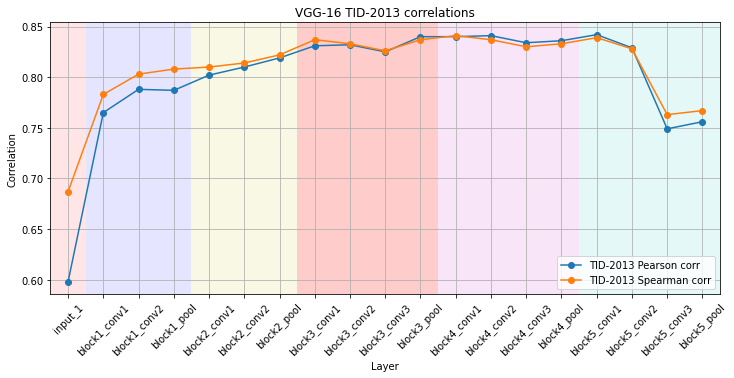

In [5]:
plt.figure(figsize=(12,5), facecolor=(1, 1, 1))
plt.plot(np.arange(19), tid_pearson, '-o', label = 'TID-2013 Pearson corr')
plt.plot(np.arange(19), tid_spearman, '-o', label = 'TID-2013 Spearman corr')
plt.axvspan(-0.5, 0.5, color='r', alpha=0.1, lw=0)
plt.axvspan(0.5, 3.5, color='b', alpha=0.1, lw=0)
plt.axvspan(3.5, 6.5, color='y', alpha=0.1, lw=0)
plt.axvspan(6.5, 10.5, color='r', alpha=0.2, lw=0)
plt.axvspan(10.5, 14.5, color='m', alpha=0.1, lw=0)
plt.axvspan(14.5, 18.5, color='c', alpha=0.1, lw=0)
plt.xticks(np.arange(19), [layer.name for layer in vgg.layers], rotation = 45)
plt.title('VGG-16 TID-2013 correlations')
plt.xlabel('Layer')
plt.ylabel('Correlation')
#plt.ylim([0.5,1])
plt.xlim([-0.5,18.5])
plt.legend(loc = 'lower right')
plt.grid()
plt.show()

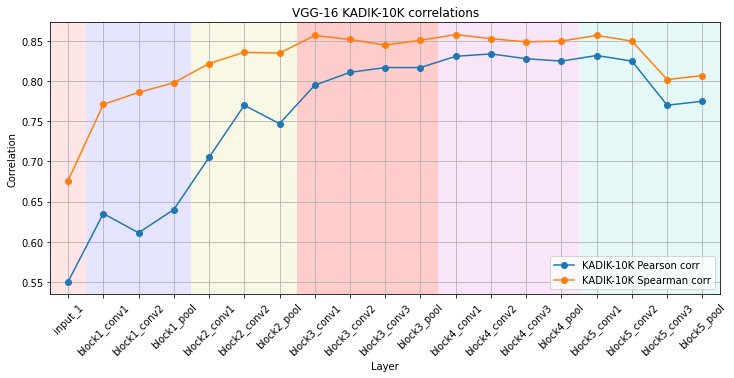

In [6]:
plt.figure(figsize=(12,5), facecolor=(1, 1, 1))
plt.plot(np.arange(19), kadik_pearson, '-o', label = 'KADIK-10K Pearson corr')
plt.plot(np.arange(19), kadik_spearman, '-o', label = 'KADIK-10K Spearman corr')
plt.axvspan(-0.5, 0.5, color='r', alpha=0.1, lw=0)
plt.axvspan(0.5, 3.5, color='b', alpha=0.1, lw=0)
plt.axvspan(3.5, 6.5, color='y', alpha=0.1, lw=0)
plt.axvspan(6.5, 10.5, color='r', alpha=0.2, lw=0)
plt.axvspan(10.5, 14.5, color='m', alpha=0.1, lw=0)
plt.axvspan(14.5, 18.5, color='c', alpha=0.1, lw=0)
plt.xticks(np.arange(19), [layer.name for layer in vgg.layers], rotation = 45)
plt.title('VGG-16 KADIK-10K correlations')
plt.xlabel('Layer')
plt.ylabel('Correlation')
#plt.ylim([0.5,1])
plt.xlim([-0.5,18.5])
plt.legend(loc = 'lower right')
plt.grid()
plt.show()

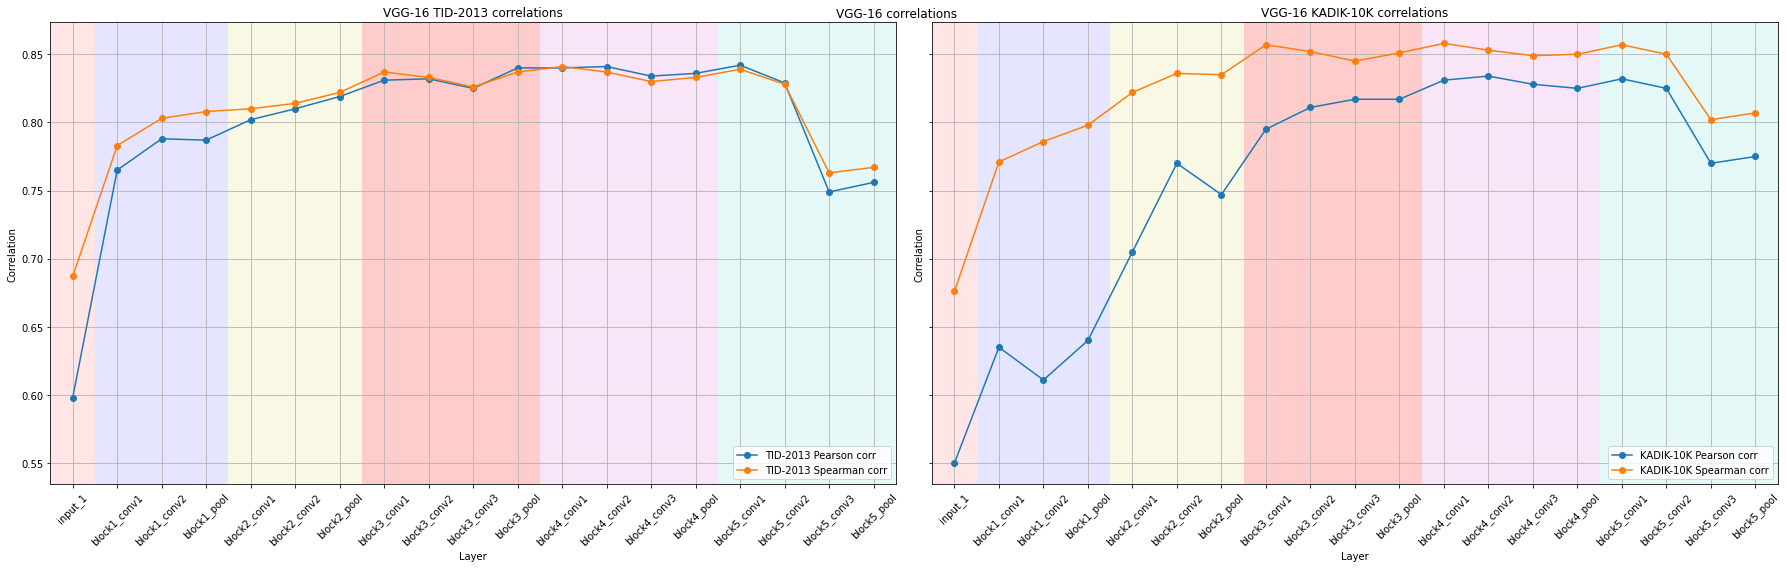

In [7]:
fig, ax = plt.subplots(1,2, sharey=True, figsize = (25,8))
ax[0].plot(np.arange(19), tid_pearson, '-o', label = 'TID-2013 Pearson corr')
ax[0].plot(np.arange(19), tid_spearman, '-o', label = 'TID-2013 Spearman corr')
ax[0].axvspan(-0.5, 0.5, color='r', alpha=0.1, lw=0)
ax[0].axvspan(0.5, 3.5, color='b', alpha=0.1, lw=0)
ax[0].axvspan(3.5, 6.5, color='y', alpha=0.1, lw=0)
ax[0].axvspan(6.5, 10.5, color='r', alpha=0.2, lw=0)
ax[0].axvspan(10.5, 14.5, color='m', alpha=0.1, lw=0)
ax[0].axvspan(14.5, 18.5, color='c', alpha=0.1, lw=0)
ax[0].set_xticks(np.arange(19), [layer.name for layer in vgg.layers], rotation = 45)
ax[0].set_title('VGG-16 TID-2013 correlations')
ax[0].set_xlabel('Layer')
ax[0].set_ylabel('Correlation')
ax[0].set_xlim([-0.5,18.5])
ax[0].legend(loc = 'lower right')
ax[0].grid()

ax[1].plot(np.arange(19), kadik_pearson, '-o', label = 'KADIK-10K Pearson corr')
ax[1].plot(np.arange(19), kadik_spearman, '-o', label = 'KADIK-10K Spearman corr')
ax[1].axvspan(-0.5, 0.5, color='r', alpha=0.1, lw=0)
ax[1].axvspan(0.5, 3.5, color='b', alpha=0.1, lw=0)
ax[1].axvspan(3.5, 6.5, color='y', alpha=0.1, lw=0)
ax[1].axvspan(6.5, 10.5, color='r', alpha=0.2, lw=0)
ax[1].axvspan(10.5, 14.5, color='m', alpha=0.1, lw=0)
ax[1].axvspan(14.5, 18.5, color='c', alpha=0.1, lw=0)
ax[1].set_xticks(np.arange(19), [layer.name for layer in vgg.layers], rotation = 45)
ax[1].set_title('VGG-16 KADIK-10K correlations')
ax[1].set_xlabel('Layer')
ax[1].set_ylabel('Correlation')
ax[1].set_xlim([-0.5,18.5])
ax[1].legend(loc = 'lower right')
ax[1].grid()
fig.tight_layout()
plt.suptitle('VGG-16 correlations')
plt.show()
#plt.savefig('VGG_correlations.png', dpi = 1000)